In [1]:
import json

import pandas as pd
import numpy as np

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
# Season info
season_info = {
    "season_str": ["2021-22", "2020-21", "2018-19", "2017-18", "2016-17", "2015-16"],
    "year": ["2022", "2021", "2019", "2018", "2017", "2016"],
    "tourney_start_date": ["2022-03-15","2021-03-18", "2019-03-19", "2018-03-13", "2017-03-14", "2016-03-15"]
}

In [3]:
# https://www.sportsbookreviewsonline.com/scoresoddsarchives/ncaabasketball/

vegas_dfs = []
for season_year, season_str in zip(season_info["year"], season_info["season_str"]):
    print("Loading Vegas data from", season_year)
    df = pd.read_excel(f"ncaa basketball {season_str}.xlsx", usecols="A:K")
    df["season"] = season_year
    vegas_dfs.append(df)
vegas_df = pd.concat(vegas_dfs)

Loading Vegas data from 2022
Loading Vegas data from 2021
Loading Vegas data from 2019
Loading Vegas data from 2018
Loading Vegas data from 2017
Loading Vegas data from 2016


In [4]:
fte_dfs = []
for year in season_info["year"]:
    print("Downloading FiveThirtyEight data from", year)
    fte_dfs.append(pd.read_csv(f"https://projects.fivethirtyeight.com/march-madness-api/{year}/fivethirtyeight_ncaa_forecasts.csv", parse_dates=["forecast_date"]))
fte_df = pd.concat(fte_dfs)

In [5]:
# Parse date and add year
vegas_df["date_parsed"] = pd.to_datetime(vegas_df["Date"].astype(str).str.zfill(4) + vegas_df["season"].astype(str), format="%m%d%Y")

In [6]:
# Decrement year for games occuring in previous calendar year
vegas_df["date_parsed"] = vegas_df["date_parsed"].mask(vegas_df["date_parsed"].dt.month > 5, vegas_df["date_parsed"] - pd.offsets.DateOffset(years=1))

In [7]:
# Filter out games which are not Tournament games
filtered_dfs = []
for season, tourney_start_date in zip(season_info["year"], season_info["tourney_start_date"]):
    filtered_dfs.append(vegas_df[(vegas_df["season"] == season) & (vegas_df["date_parsed"] >= tourney_start_date)])

vegas_df = pd.concat(filtered_dfs)

In [8]:
# Map names in Vegas dataset to mat
with open("name_map.json", "r") as f:
    name_map = json.load(f)

vegas_df["Team"].replace(name_map, inplace=True)
vegas_df = vegas_df.dropna()

In [9]:
# Merge games into one row and keep only relevant columns
ml_df = vegas_df.iloc[1::2].reset_index().join(vegas_df.iloc[0::2].reset_index(), rsuffix='_2') # 

In [10]:
# Spread and Total score are mixed together in Open and Close columns, since the spread will always be lower than the total, we can take the min to get the spread
ml_df["spread"] = np.minimum(pd.to_numeric(ml_df["Close"], errors='coerce').fillna(0), pd.to_numeric(ml_df["Close_2"], errors='coerce').fillna(0))
# Spreads are all positive, so we need to use the moneyline to apply the correct sign
ml_df["spread"] = ml_df["spread"].where(ml_df["ML"] > 0, -ml_df["spread"], axis=0)
ml_df = ml_df[["date_parsed", "season", "Team", "Team_2", "ML", "ML_2", "spread", "VH", "VH_2", "Final", "Final_2"]]

In [11]:
# Keep only Mento_numpyrnament predictions
fte_df = fte_df[fte_df["gender"] == "mens"].sort_values("forecast_date")

In [12]:
def get_538_win_prob(row, fte_df):
    """
    Get win probability for each game using FiveThirtyEight forecasts
    """
    # Get rows with prediction for current team and forecast date before game date
    fte_rows = fte_df[(fte_df["team_name"] == row["Team"]) & (fte_df["forecast_date"] < row["date_parsed"])]
    if len(fte_rows) > 1:
        # Take the latest prediction
        fte_row = fte_rows.iloc[-1]
    else:
        # No prediction is available
        return np.NaN
    
    # Iterate through rd1-rd7 probabilities
    # The win probability for a given game is equivalent to the probability of advancing to the next round
    for i in range(1, 8):
        if ((fte_row[f"rd{i}_win"] < 1.0) and (fte_row[f"rd{i}_win"] > 0.0)):
            return fte_row[f"rd{i}_win"]
    
    # No probability was found
    return np.NaN

In [13]:
ml_df["FiveThirtyEight Win Prob"] = ml_df.apply(get_538_win_prob, fte_df=fte_df, axis=1)
ml_df["fte_spread_raw"] = 400/30.464 * np.log10(1/ml_df["FiveThirtyEight Win Prob"] - 1)
ml_df["FiveThirtyEight Spread"] = round(ml_df["fte_spread_raw"] * 2) / 2

In [14]:
ml_df = ml_df.dropna()

In [15]:
# helper function to convert moneylines into probabilties
def ml_to_prob(ml):
    if ml > 0:
        return 100 / (100 + ml)
    else:
        ml_pos = ml * -1
        return ml_pos / (100 + ml_pos)

In [16]:
ml_df["ml_prob1"] = ml_df["ML"].apply(ml_to_prob)
ml_df["ml_prob2"] = ml_df["ML_2"].apply(ml_to_prob)

# adjust moneyline probabilities for juice/vig
ml_df["ml_prob_adj1"] = ml_df.ml_prob1 / (ml_df.ml_prob1 + ml_df.ml_prob2)
ml_df["ml_prob_adj2"] = ml_df.ml_prob2 / (ml_df.ml_prob1 + ml_df.ml_prob2)

In [17]:
# create ground truth column, return 1 if team1 won and 0 if they lost
ml_df["team1_win"] = (ml_df.Final > ml_df.Final_2).astype(int)

# ground truth column for spreads
# make sure we subtract in the correct order to follow convention of favored teams having negative spreads
ml_df["point_diff"] = (ml_df.Final_2 - ml_df.Final).astype(int)

In [18]:
ml_df["team1_cover"] = (ml_df.Final + ml_df.spread > ml_df.Final_2).astype(int)
print(f"Vegas Team 1 Cover Rate: {ml_df.team1_cover.mean():.4%}")
print(f"FiveThirtyEight Team 1 Cover Rate: {(ml_df.Final + ml_df['FiveThirtyEight Spread'] > ml_df.Final_2).mean():.4%}")

Vegas Team 1 Cover Rate: 45.1282%
FiveThirtyEight Team 1 Cover Rate: 45.8974%


In [19]:
# Compute Brier scores to compare models
from sklearn.metrics import brier_score_loss, mean_squared_error

def get_brier_scores(df):
    fte_brier = brier_score_loss(df.team1_win, df["FiveThirtyEight Win Prob"])
    vegas_brier = brier_score_loss(df.team1_win, df.ml_prob_adj1)
    fte_skill = 1 - fte_brier / vegas_brier
    
    return fte_brier, vegas_brier, fte_skill


def get_mse(df):
    fte_mse = mean_squared_error(df.point_diff, df["FiveThirtyEight Spread"])
    vegas_mse = mean_squared_error(df.point_diff, df.spread)
    fte_skill = 1 - fte_mse / vegas_mse
    
    return fte_mse, vegas_mse, fte_skill

In [20]:
fte_brier, vegas_brier, fte_skill = get_brier_scores(ml_df)
fte_mse, vegas_mse, fte_mse_skill = get_mse(ml_df)
results = [
    {
        "season": "All Seasons",
        "FiveThirtyEight Brier score": fte_brier,
        "Vegas Moneyline Brier score": vegas_brier,
        "FiveThirtyEight Skill score over Vegas (probabilities)": fte_skill,
        "FiveThirtyEight MSE": fte_mse,
        "Vegas Spread MSE": vegas_mse,
        "FiveThirtyEight Skill score over Vegas (spreads)": fte_mse_skill
    }
]
for season in season_info["year"]:
    fte_brier, vegas_brier, fte_skill = get_brier_scores(ml_df[ml_df["season"] == season])
    fte_mse, vegas_mse, fte_mse_skill = get_mse(ml_df[ml_df["season"] == season])
    results.append({
        "season": season,
        "FiveThirtyEight Brier score": fte_brier,
        "Vegas Moneyline Brier score": vegas_brier,
        "FiveThirtyEight Skill score over Vegas (probabilities)": fte_skill,
        "FiveThirtyEight MSE": fte_mse,
        "Vegas Spread MSE": vegas_mse,
        "FiveThirtyEight Skill score over Vegas (spreads)": fte_mse_skill
    })

pd.DataFrame(results).style.format({
    "FiveThirtyEight Skill score over Vegas (probabilities)": '{:+,.4%}',
    "FiveThirtyEight Skill score over Vegas (spreads)": '{:+,.4%}'
})

,season,FiveThirtyEight Brier score,Vegas Moneyline Brier score,FiveThirtyEight Skill score over Vegas (probabilities),FiveThirtyEight MSE,Vegas Spread MSE,FiveThirtyEight Skill score over Vegas (spreads)
0,All Seasons,0.191028,0.191346,+0.1662%,137.642949,135.906410,-1.2777%
1,2022,0.209117,0.210692,+0.7476%,148.806818,146.371212,-1.6640%
2,2021,0.220430,0.214666,-2.6850%,152.757692,150.342308,-1.6066%
3,2019,0.158121,0.161184,+1.9003%,133.333333,135.746212,+1.7775%
4,2018,0.206192,0.205400,-0.3858%,151.863636,148.681818,-2.1400%
5,2017,0.174317,0.170528,-2.2217%,109.280769,106.630769,-2.4852%
6,2016,0.177354,0.185275,+4.2755%,129.096774,126.895161,-1.7350%


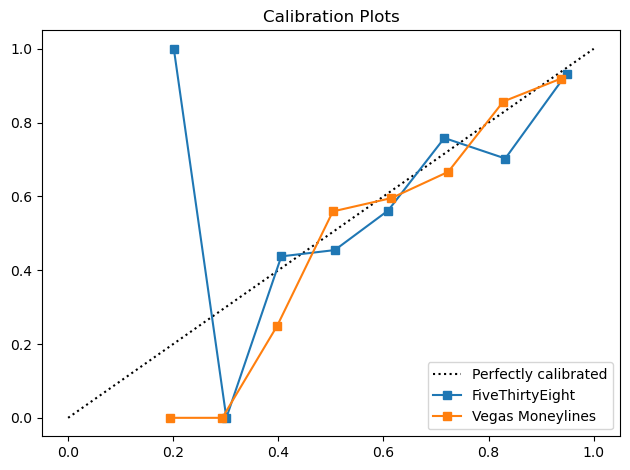

In [21]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt


pos_frac_fte, mean_pred_fte = calibration_curve(ml_df.team1_win, ml_df["FiveThirtyEight Win Prob"], n_bins=9)
pos_frac_vegas, mean_pred_vegas = calibration_curve(ml_df.team1_win, ml_df.ml_prob_adj1, n_bins=9)


plt.figure()

plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(mean_pred_fte, pos_frac_fte, "s-", label="%s" % ("FiveThirtyEight", ))
plt.plot(mean_pred_vegas, pos_frac_vegas, "s-", label="%s" % ("Vegas Moneylines", ))
plt.legend()
plt.title("Calibration Plots")
plt.tight_layout()
plt.show()

# Wagering Strategy Testing

In [22]:
# Set max wager size
BANKROLL = 100
MAX_WAGER_FRAC = 0.15
MIN_PROFIT_FRAC = 0.05

# Compute information about wager given the current bankroll, Kelly Criterion values, and which team won
def compute_wager_info(bankroll, kc1, kc2, tm1_odds, tm2_odds, tm1_win):
    wager_amt = 0
    wager_tm = 0
    bet_profit = 0
    bet_won = np.NaN
    
    if kc1 > 0 and kc1 > kc2:
        wager_tm = 1
        kc = kc1
        odds = tm1_odds
    elif kc2 > 0 and kc2 > kc1:
        wager_tm = 2
        kc = kc2
        odds = tm2_odds
    else:
        return wager_tm, wager_amt, bet_won, bet_profit, bankroll
    
    wager_amt = min(kc, MAX_WAGER_FRAC) * bankroll
    
    potential_profit = (odds - 1) * wager_amt
    
    if potential_profit < MIN_PROFIT_FRAC * bankroll:
        # Don't make a wager if potential profit doesn't meet a threshold
        return 0, 0, np.NaN, 0, bankroll
    if (wager_tm == 1 and tm1_win) or (wager_tm == 2 and not tm1_win):
        # Won the bet
        bet_won = True
        bet_profit = potential_profit
    elif (wager_tm == 2 and tm1_win) or (wager_tm == 1 and not tm1_win):
        bet_won = False
        bet_profit = -wager_amt
    
    bankroll += bet_profit
        
    return wager_tm, wager_amt, bet_won, bet_profit, bankroll

In [23]:
ml_df.head()

,date_parsed,season,Team,Team_2,ML,ML_2,spread,VH,VH_2,Final,Final_2,FiveThirtyEight Win Prob,fte_spread_raw,FiveThirtyEight Spread,ml_prob1,ml_prob2,ml_prob_adj1,ml_prob_adj2,team1_win,point_diff,team1_cover
0,2022-03-15,2022,Texas Southern,TexasA&MCorpus,-175,155,-3.5,N,N,76.0,67.0,0.640259,-3.287362,-3.5,0.636364,0.392157,0.618718,0.381282,1,-9,1
12,2022-03-16,2022,Rutgers,Notre Dame,-120,100,-1.0,N,N,87.0,89.0,0.439896,1.377609,1.5,0.545455,0.500000,0.521739,0.478261,0,2,0
13,2022-03-16,2022,Wright State,Bryant,-145,125,-2.5,N,N,93.0,82.0,0.686563,-4.471255,-4.5,0.591837,0.444444,0.571116,0.428884,1,-11,1
26,2022-03-17,2022,Connecticut,New Mexico State,-280,240,-6.5,N,N,63.0,70.0,0.862753,-10.482999,-10.5,0.736842,0.294118,0.714715,0.285285,0,7,0
27,2022-03-17,2022,Arkansas,Vermont,-220,190,-5.0,N,N,75.0,71.0,0.717856,-5.325194,-5.5,0.687500,0.344828,0.665971,0.334029,1,-4,0


In [24]:
spread_odds = 1.9

ml_df["ml_dec1"] = 1 / ml_df.ml_prob1
ml_df["ml_dec2"] = 1 / ml_df.ml_prob2
ml_df["kc1"] = ml_df["FiveThirtyEight Win Prob"] - ((1 - ml_df["FiveThirtyEight Win Prob"]) / (ml_df.ml_dec1 - 1))
ml_df["kc2"] = (1 - ml_df["FiveThirtyEight Win Prob"]) - (ml_df["FiveThirtyEight Win Prob"] / (ml_df.ml_dec2 - 1))

ml_df["fte_cover_prob"] = 1 / (1+10**(30.464/400*(ml_df.fte_spread_raw - ml_df.spread)))
ml_df["spread_kc1"] = ml_df["fte_cover_prob"] - ((1 - ml_df["fte_cover_prob"]) / (spread_odds - 1))
ml_df["spread_kc2"] = 1 - ml_df["fte_cover_prob"] - ((ml_df["fte_cover_prob"]) / (spread_odds - 1))
ml_df["spread_dec1"] = spread_odds
ml_df["spread_dec2"] = spread_odds

In [25]:
ml_df = ml_df.sort_values("date_parsed")

In [26]:
def track_bankroll(df, spreads_only=False):
    start_bankroll = BANKROLL
    df["wager_team"] = np.nan
    df["wager_amt"] = np.nan
    df["bet_won"] = np.nan
    df["bet_profit"] = np.nan
    df["bankroll"] = np.nan
    
    if spreads_only:
        df.loc[df.index[0], ["wager_team", "wager_amt", "bet_won", "bet_profit", "bankroll"]] = compute_wager_info(start_bankroll, *df[["spread_kc1", "spread_kc2", "spread_dec1", "spread_dec2", "team1_cover"]].iloc[0])
    else:
        df.loc[df.index[0], ["wager_team", "wager_amt", "bet_won", "bet_profit", "bankroll"]] = compute_wager_info(start_bankroll, *df[["kc1", "kc2", "ml_dec1", "ml_dec2", "team1_win"]].iloc[0])

    for i in range(1, df.shape[0]):
        prev_bankroll = df.loc[df.index[i - 1], "bankroll"]
        row = df.loc[df.index[i]]
        df.loc[df.index[i], ["wager_team", "wager_amt", "bet_won", "bet_profit", "bankroll"]] = compute_wager_info(prev_bankroll, *row[["kc1", "kc2", "ml_dec1", "ml_dec2", "team1_win"]])
    
    return df

In [27]:
for season in season_info["year"]:
    ml_df = track_bankroll(ml_df[ml_df["season"] == season])
    spread_df = track_bankroll(ml_df[ml_df["season"] == season], spreads_only=True)
    # plt.figure()
    # plt.plot(season_df["date_parsed"], season_df["bankroll"])
    # # plt.legend()
    # plt.title(season + " Bankroll over Time")
    # plt.tight_layout()
    # plt.show()
    print(f"{season} Final bankroll (MLs only): {ml_df['bankroll'].iloc[-1]:.2f}")
    print(f"{season} Final bankroll (Spreads only): {spread_df['bankroll'].iloc[-1]:.2f}")

C:\Users\Supra\AppData\Local\Temp\ipykernel_1284\3519920246.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["wager_team"] = np.nan
C:\Users\Supra\AppData\Local\Temp\ipykernel_1284\3519920246.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["wager_amt"] = np.nan
C:\Users\Supra\AppData\Local\Temp\ipykernel_1284\3519920246.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

2022 Final bankroll (MLs only): 118.15
2022 Final bankroll (Spreads only): 118.15


IndexError: single positional indexer is out-of-bounds